In [15]:
import pandas as pd
import os
from nltk.tokenize import RegexpTokenizer
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.patches as mpatches
import matplotlib

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

pd.set_option("display.max_colwidth", 80)

%matplotlib inline

In [6]:
df_trn = pd.read_csv("/home/ubuntu/data/cleaned/disaster_response_messages_training.csv", dtype={"split": str, "message": str, "original": str, "genre": str})
df_trn["tokens"] = df_trn["tokens"].apply(ast.literal_eval)
df_trn = df_trn.sample(frac=1.0, random_state=42)
df_trn.head(40)

,Unnamed: 0,id,split,message,original,genre,related,PII,request,offer,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,message_std,tokens
16944,16944,24527,train,This week the government launched a 100-million-dollar climate resilience pr...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,this week the government launched a 100 million dollar climate resilience pr...,"[this, week, the, government, launched, a, 100, million, dollar, climate, re..."
20803,20803,29923,train,"Whatever the political calculations in Jakarta, disgruntled residents here b...",NaN,news,1,0,1,0,...,0,0,0,0,0,0,0,1,"whatever the political calculations in jakarta, disgruntled residents here b...","[whatever, the, political, calculations, in, jakarta, disgruntled, residents..."
6836,6836,9512,train,Bases insolubles Cu(OH)2-Fe(OH)3-Cr(OH)2-CuOH-Zn(OH)2-Al(OH)3-Pb(OH)2 Base I...,Bases insolubles Cu ( OH ) 2-Fe ( OH ) 3-Cr ( OH ) 2-CuOH-Zn ( OH ) 2-Al ( O...,direct,0,0,0,0,...,0,0,0,0,0,0,0,0,bases insolubles cu(oh)2 fe(oh)3 cr(oh)2 cuoh zn(oh)2 al(oh)3 pb(oh)2 base i...,"[bases, insolubles, cu, oh, 2, fe, oh, 3, cr, oh, 2, cuoh, zn, oh, 2, al, oh..."
5865,5865,8227,train,I want to get contact with an Organisation (ONG) to let it know that I have ...,Mwen bezwen antre an kontak ak 0NG paske m gen anpil problem ak moun ki mala...,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,i want to get contact with an organisation (ong) to let it know that i have ...,"[i, want, to, get, contact, with, an, organisation, ong, to, let, it, know, ..."
7628,7628,10665,train,"The SMS: Hello at you operators, I will ask you for information. Is there wo...","Bonjour vous operateurs,je vais vous demander une information.Est qu'il aur...",direct,1,0,0,0,...,0,0,0,0,0,0,0,0,"the sms hello at you operators, i will ask you for information is there wo...","[the, sms, hello, at, you, operators, i, will, ask, you, for, information, i..."
11968,11968,17622,train,The China Meteorological Administration issued a red alert early that day fo...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,the china meteorological administration issued a red alert early that day fo...,"[the, china, meteorological, administration, issued, a, red, alert, early, t..."
11062,11062,16382,train,"In the Philippines, millions of terrified flood survivors, many of them shel...",NaN,news,1,0,0,0,...,1,1,1,0,0,0,0,0,"in the philippines, millions of terrified flood survivors, many of them shel...","[in, the, philippines, millions, of, terrified, flood, survivors, many, of, ..."
6024,6024,8431,train,"If I have diarrhe what can I do,I am a survivor",Si m gen kolerin kisa pou m fe m se yon riskape,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,"if i have diarrhe what can i do,i am a survivor","[if, i, have, diarrhe, what, can, i, do, i, am, a, survivor]"
11216,11216,16587,train,The engineers have trained thousands of people to build and design their hou...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,the engineers have trained thousands of people to build and design their hou...,"[the, engineers, have, trained, thousands, of, people, to, build, and, desig..."
17064,17064,24686,train,Assessment missions by government authorities were conducted in extremely di...,NaN,news,0,0,0,0,...,0,0,0,0,0,0,0,0,assessment missions by government authorities were conducted in extremely di...,"[assessment, missions, by, government, authorities, were, conducted, in, ext..."


In [7]:
df_val = pd.read_csv("/home/ubuntu/data/cleaned/disaster_response_messages_validation.csv", dtype={"split": str, "message": str, "original": str, "genre": str})
df_val["tokens"] = df_val["tokens"].apply(ast.literal_eval)
df_val.head()

,Unnamed: 0,id,split,message,original,genre,related,PII,request,offer,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,message_std,tokens
0,0,8,validation,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ak timoun yo. Mesi se john jea...",direct,1,0,0,0,...,0,0,0,0,0,0,0,0,looking for someone but no name,"[looking, for, someone, but, no, name]"
1,1,18,validation,I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in S...,"Nou kwadebouke, nou gen pwoblem sant m yo nan santo 15",direct,1,0,1,0,...,0,0,0,0,0,0,0,1,i am in croix des bouquets we have health issues they ( workers ) are in s...,"[i, am, in, croix, des, bouquets, we, have, health, issues, they, workers, a..."
2,2,28,validation,are you going to call me or do you want me to call ou? let me know?,Eske se rele nap relem oubyen se mwen kap rele nou?si se mwen eske,direct,0,0,0,0,...,0,0,0,0,0,0,0,0,are you going to call me or do you want me to call ou? let me know?,"[are, you, going, to, call, me, or, do, you, want, me, to, call, ou, let, me..."
3,3,38,validation,"People I'm at Delma 2, we don't anything what so ever, please provide us wit...",MEZANMI MWEN MWEN NAN DELMA 2 NOU TR MAN MAL NOU PA JAN M JWEN ANY,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,"people i'm at delma 2, we don't anything what so ever, please provide us wit...","[people, i, m, at, delma, 2, we, don, t, anything, what, so, ever, please, p..."
4,4,48,validation,"How we can find food and water? we have people in many differents needs, and...",Comment nou ka jwen dlo ak manje nou gen moun ki gen tout kalte pwoblem nan ...,direct,1,0,0,0,...,0,0,0,0,0,0,0,0,"how we can find food and water? we have people in many differents needs, and...","[how, we, can, find, food, and, water, we, have, people, in, many, different..."


In [8]:
cv = CountVectorizer()
X_trn = cv.fit_transform(df_trn["message_std"])
y_trn = df_trn["related"]

X_val = cv.transform(df_val["message_std"])
y_val = df_val["related"]

In [11]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_trn, y_trn)

y_prd = clf.predict(X_val)

In [14]:
def get_metrics(y_truth, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_truth, y_predicted, pos_label=None, average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_truth, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_truth, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_truth, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_val, y_prd)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.778, precision = 0.793, recall = 0.778, f1 = 0.784


In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

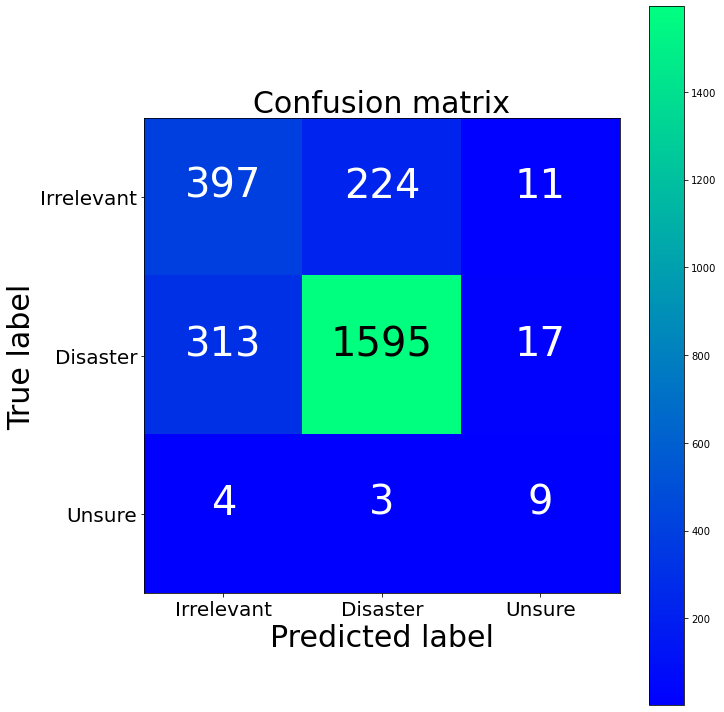

[[ 397  224   11]
 [ 313 1595   17]
 [   4    3    9]]


In [17]:
cm = confusion_matrix(y_val, y_prd)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [18]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(cv, clf, 10)

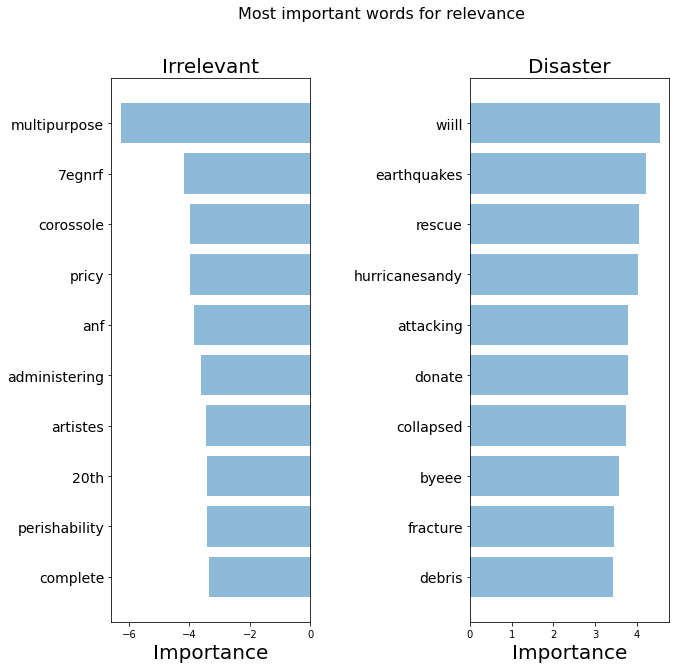

In [19]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")